Ques_1 
I and II Part  

Performing speaker verification (evaluation) using the list of trial pairs - VoxCeleb1 (cleaned) file  Using Hubert Model

/DATA1/miniconda3/envs/Speech_Ass_2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing Speaker Identification Accuracy: 100%|██████████| 37611/37611 [48:12<00:00, 13.00it/s]  


EER: 48.12%
TAR@1%FAR: 1.04%
Speaker Identification Accuracy: 49.99%


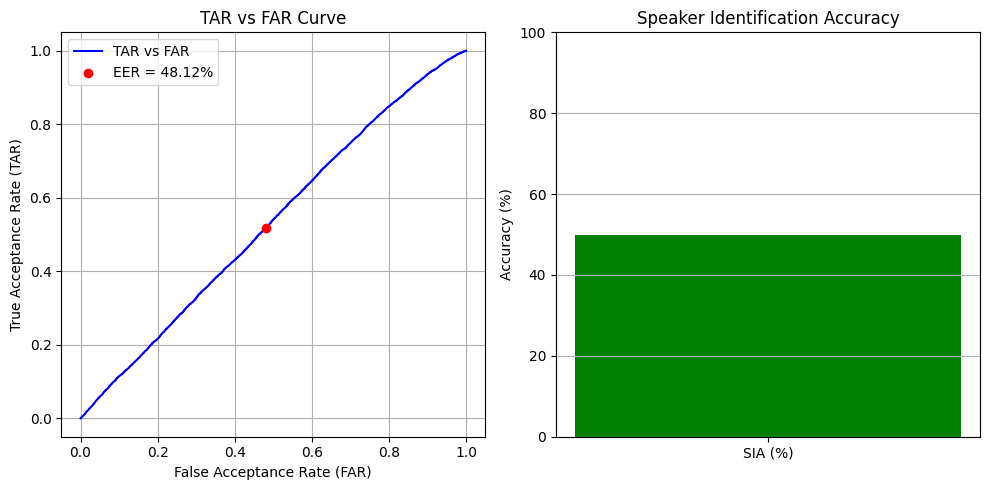

In [1]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from transformers import HubertForSequenceClassification, Wav2Vec2Processor
from sklearn.metrics import roc_curve, accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trial pairs
def load_trials(trial_file):
    with open(trial_file, 'r') as f:
        trials = [line.strip().split() for line in f.readlines()]
    return [(pair[1], pair[2], int(pair[0])) for pair in trials[:len(trials)]]     

# Compute EER, TAR@1%FAR
def compute_metrics(scores, labels):
    fpr, tpr, _ = roc_curve(labels, scores)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))] * 100
    tar_1_fpr = tpr[np.where(fpr <= 0.01)[0][-1]] * 100 if np.any(fpr <= 0.01) else 0
    return eer, tar_1_fpr, fpr, tpr

# Plot EER, TAR@1%FAR, and Speaker Identification Accuracy
def plot_metrics(fpr, tpr, eer, sia):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label="TAR vs FAR", color="blue")
    plt.scatter([eer / 100], [1 - eer / 100], color='red', label=f"EER = {eer:.2f}%", zorder=3)
    plt.xlabel("False Acceptance Rate (FAR)")
    plt.ylabel("True Acceptance Rate (TAR)")
    plt.title("TAR vs FAR Curve")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.bar(["SIA (%)"], [sia], color="green")
    plt.ylim(0, 100)
    plt.title("Speaker Identification Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    
    plt.tight_layout()
    plt.show()

# Load pre-trained model
def load_pretrained_model(model_name):
    model = HubertForSequenceClassification.from_pretrained(model_name).to(device)
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    return model, processor

# Compute Speaker Identification Accuracy
def compute_sia(model, processor, trials, vox1_path):
    predicted_labels, true_labels = [], []
    
    for file1, file2, label in tqdm(trials, desc="Computing Speaker Identification Accuracy"):
        input1, _ = torchaudio.load(os.path.join(vox1_path, file1))
        input2, _ = torchaudio.load(os.path.join(vox1_path, file2))

        input1 = processor(input1.squeeze(0), sampling_rate=16000, return_tensors="pt", padding=True).input_values.to(device)
        input2 = processor(input2.squeeze(0), sampling_rate=16000, return_tensors="pt", padding=True).input_values.to(device)

        with torch.no_grad():
            emb1 = model(input1).logits.squeeze()
            emb2 = model(input2).logits.squeeze()

        similarity = torch.cosine_similarity(emb1, emb2, dim=0).item()
        predicted_label = 1 if similarity > 0.5 else 0  # Binary prediction
        predicted_labels.append(predicted_label)
        true_labels.append(label)

    return accuracy_score(true_labels, predicted_labels) * 100

# Main execution
vox1_path = "vox1/vox1_test_wav/wav"
trial_file = "trials_clean.txt"
model_name = "facebook/hubert-large-ls960-ft"

# Load model and processor
model, processor = load_pretrained_model(model_name)

# Load trial data
trials = load_trials(trial_file)

# Evaluate pre-trained model
pre_scores, pre_labels = [], []
for file1, file2, label in tqdm(trials, desc="Evaluating Pre-trained Model"):
    input1, _ = torchaudio.load(os.path.join(vox1_path, file1))
    input2, _ = torchaudio.load(os.path.join(vox1_path, file2))

    input1 = processor(input1.squeeze(0), sampling_rate=16000, return_tensors="pt", padding=True).input_values.to(device)
    input2 = processor(input2.squeeze(0), sampling_rate=16000, return_tensors="pt", padding=True).input_values.to(device)

    with torch.no_grad():
        emb1 = model(input1).logits.squeeze()
        emb2 = model(input2).logits.squeeze()

    pre_scores.append(torch.cosine_similarity(emb1, emb2, dim=0).item())
    pre_labels.append(label)

# Compute EER and TAR@1%FAR
pre_eer, pre_tar_1_fpr,pre_fpr,pre_tpr = compute_metrics(pre_scores, pre_labels)

# Compute Speaker Identification Accuracy
pre_sia = compute_sia(model, processor, trials, vox1_path)



# Print results
print(f"EER: {pre_eer:.2f}%")
print(f"TAR@1%FAR: {pre_tar_1_fpr:.2f}%")
print(f"Speaker Identification Accuracy: {pre_sia:.2f}%")

# Plot results
plot_metrics(pre_fpr,pre_tpr,pre_eer, pre_sia)


Now fine-tune the Hubert model using LoRA (Low-Rank Adaptation) and ArcFace loss with the VoxCeleb2 Dataset

/tmp/ipykernel_669943/2119973471.py:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/14916 [00:00<?, ?it/s]/tmp/ipykernel_669943/2119973471.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 25: 100%|██████████| 14916/14916 [29:44<00:00,  8.36it/s, loss=1.88]  


Model and processor saved to checkpoints/hubert_lora_Fine-Tuned_voxceleb
EER: 22.20%
TAR@1%FAR: 23.68%
Speaker Identification Accuracy: 39.93%


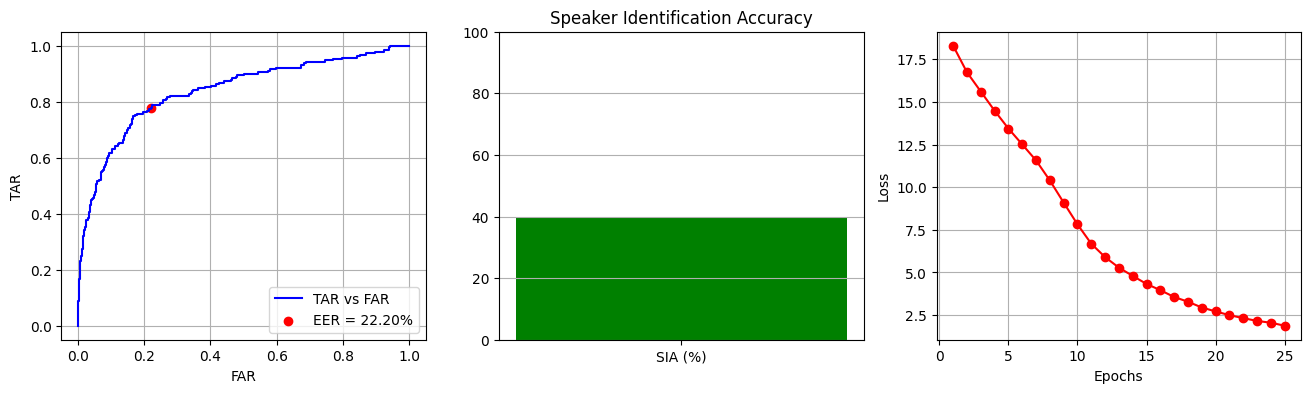

In [2]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import random
from transformers import HubertModel, Wav2Vec2Processor
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, accuracy_score
from peft import get_peft_model, LoraConfig
from tqdm import tqdm
from arcface import arcface_loss
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load VoxCeleb2 dataset
class VoxCeleb2Dataset(Dataset):
    def __init__(self, file_list, audio_path, processor):
        self.file_list = file_list
        self.audio_path = audio_path
        self.processor = processor
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        waveform, _ = torchaudio.load(os.path.join(self.audio_path, file_path))
        inputs = self.processor(waveform.squeeze(0), sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs.input_values.squeeze(0), torch.tensor(label, dtype=torch.long)

# Custom collate function
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0.0)
    labels = torch.stack(labels)
    return inputs.to(device), labels.to(device)

# Load speaker identities
audio_path = "aac/"
text_path = "vox2/vox2_test_txt/txt/"
speaker_ids = sorted(os.listdir(audio_path))
train_speakers = speaker_ids[:100]
test_speakers = speaker_ids[100:]

# Collect file paths
train_files, test_files = [], []
for idx, speaker in enumerate(speaker_ids):
    speaker_audio_dir = os.path.join(audio_path, speaker)
    if os.path.isdir(speaker_audio_dir):
        for session in os.listdir(speaker_audio_dir):
            audio_session_dir = os.path.join(speaker_audio_dir, session)
            if os.path.isdir(audio_session_dir):
                for file in os.listdir(audio_session_dir):
                    if file.endswith(".m4a"):
                        if speaker in train_speakers:
                            train_files.append((os.path.join(speaker, session, file), idx))
                        else:
                            test_files.append((os.path.join(speaker, session, file), idx))

# Reduce dataset size for efficiency
import random
random.seed(42)
train_files = random.sample(train_files, int(len(train_files)*1))  
test_files = random.sample(test_files, int(len(test_files)*1))


# Load model and processor
model_name = "facebook/hubert-large-ls960-ft"
model = HubertModel.from_pretrained(model_name).to(device)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Apply LoRA fine-tuning
peft_config = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.1, target_modules=["intermediate_dense", "output_dense"])
model = get_peft_model(model, peft_config).to(device)

# Define training parameters
batch_size = 2  # Increased for better GPU utilization
train_dataset = VoxCeleb2Dataset(train_files, audio_path, processor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_dataset = VoxCeleb2Dataset(test_files, audio_path, processor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

embedding_size = model.config.hidden_size
num_classes = len(train_speakers)
criterion = arcface_loss(embedding_size, num_classes, scale=30.0, margin=0.5).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = GradScaler()

# Train the model
model.train()
loss_values = []
for epoch in range(25):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for inputs, labels in progress_bar:
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs).last_hidden_state[:, 0, :]
            outputs = F.normalize(outputs, p=2, dim=1)
            labels_one_hot = F.one_hot(labels, num_classes=num_classes).float().to(device)
            loss = criterion(outputs, labels_one_hot)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(train_loader))
    loss_values.append(total_loss / len(train_loader))

# Save model checkpoint
# Create output directory
output_dir = "checkpoints/hubert_lora_Fine-Tuned_voxceleb"
os.makedirs(output_dir, exist_ok=True)

# Save model with PEFT (LoRA) applied
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)
print(f"Model and processor saved to {output_dir}")




# Compute EER and TAR@1%FAR
def compute_metrics(scores, labels):
    scores = np.array(scores)
    labels = np.array(labels)
    fpr, tpr, _ = roc_curve(labels, scores)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))] * 100
    tar_1_fpr = tpr[np.where(fpr <= 0.01)[0][-1]] * 100 if np.any(fpr <= 0.01) else 0
    return eer, tar_1_fpr, fpr, tpr

# Compute similarity scores
fin_scores, fin_labels = [], []
for inputs, labels_batch in test_loader:
    with torch.no_grad():
        outputs = model(inputs).last_hidden_state[:, 0, :]
        outputs = F.normalize(outputs, p=2, dim=1).cpu().numpy()
    for i in range(len(outputs)):
        for j in range(i + 1, len(outputs)):
            similarity = np.dot(outputs[i], outputs[j])
            fin_scores.append(similarity)
            fin_labels.append(1 if labels_batch[i] == labels_batch[j] else 0)

fin_eer,fin_tar_1_far,fin_fpr,fin_tpr = compute_metrics(fin_scores, fin_labels)
identification_accuracy = accuracy_score(fin_labels, (np.array(fin_scores) > 0).astype(int)) * 100

# Print results
print(f"EER: {fin_eer:.2f}%")
print(f"TAR@1%FAR: {fin_tar_1_far:.2f}%")
print(f"Speaker Identification Accuracy: {identification_accuracy:.2f}%")

# Plot results
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(fin_fpr, fin_tpr, label="TAR vs FAR", color="blue")
plt.scatter([fin_eer / 100], [1 - fin_eer / 100], color='red', label=f"EER = {fin_eer:.2f}%")
plt.xlabel("FAR")
plt.ylabel("TAR")
plt.legend()
plt.grid(True)
plt.subplot(1, 3, 2)
plt.bar(["SIA (%)"], [identification_accuracy], color="green")
plt.ylim(0, 100)
plt.title("Speaker Identification Accuracy")
plt.grid(axis="y")
plt.subplot(1, 3, 3)
plt.plot(range(1, len(loss_values) + 1), loss_values, marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Evaluating Pre-Trained Hubert Model and Fine-Tuned Hubert Model
Compare the performance of the pre-trained and fine-tuned model on the list of trial pairs - VoxCeleb1 (cleaned) dataset using the following metrics: EER(in %), TAR@1%FAR and Speaker Identification Accuracy. 



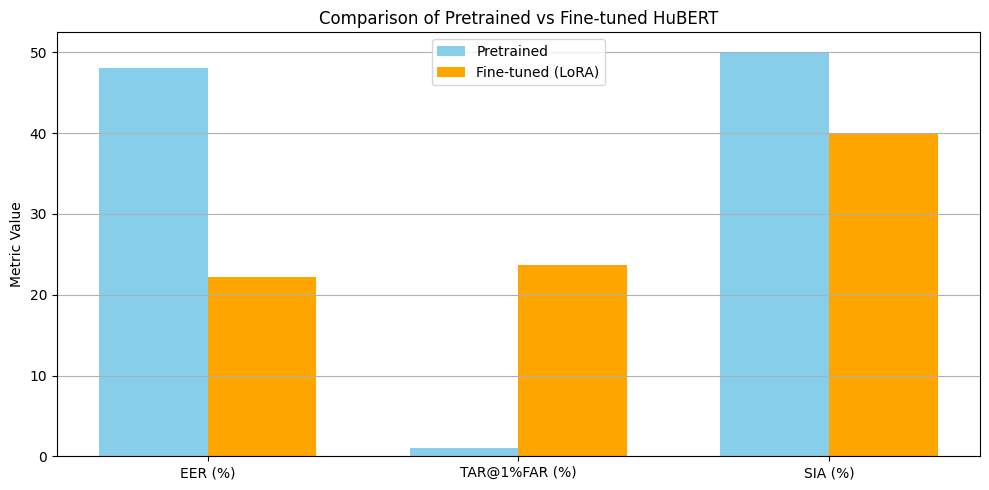

In [3]:
# Pretrained Results (already computed)
pre_eer = pre_eer
pre_tar1 = pre_tar_1_fpr
pre_sia = pre_sia

# Finetuned Results (already computed)
fin_eer =fin_eer
fin_tar1 = fin_tar_1_far
fin_sia = identification_accuracy

# Collect into arrays for plotting
metrics = ['EER (%)', 'TAR@1%FAR (%)', 'SIA (%)']
pretrained_vals = [pre_eer, pre_tar1, pre_sia]
finetuned_vals = [fin_eer, fin_tar1, fin_sia]

# Plotting
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, pretrained_vals, width, label='Pretrained', color='skyblue')
plt.bar(x + width/2, finetuned_vals, width, label='Fine-tuned (LoRA)', color='orange')
plt.xticks(x, metrics)
plt.ylabel("Metric Value")
plt.title("Comparison of Pretrained vs Fine-tuned HuBERT")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


More Detailed Analysis 

In [4]:
from sklearn.metrics import det_curve
import seaborn as sns

# ROC Curve
def plot_roc_curve(pre_scores, pre_labels, fin_scores, fin_labels):
    fpr_pre, tpr_pre, _ = roc_curve(pre_labels, pre_scores)
    fpr_fin, tpr_fin, _ = roc_curve(fin_labels, fin_scores)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_pre, tpr_pre, label="Pretrained", linestyle='--')
    plt.plot(fpr_fin, tpr_fin, label="Fine-tuned", linestyle='-')
    plt.xlabel("False Acceptance Rate (FAR)")
    plt.ylabel("True Acceptance Rate (TAR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# DET Curve
def plot_det_curve(pre_scores, pre_labels, fin_scores, fin_labels):
    fpr_pre, fnr_pre, _ = det_curve(pre_labels, pre_scores)
    fpr_fin, fnr_fin, _ = det_curve(fin_labels, fin_scores)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_pre, fnr_pre, label="Pretrained", linestyle='--')
    plt.plot(fpr_fin, fnr_fin, label="Fine-tuned", linestyle='-')
    plt.xlabel("False Acceptance Rate (FAR)")
    plt.ylabel("False Rejection Rate (FRR)")
    plt.title("DET Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Score Distribution
def plot_score_distribution(pre_scores, pre_labels, fin_scores, fin_labels):
    pre_genuine = [s for s, l in zip(pre_scores, pre_labels) if l == 1]
    pre_imposter = [s for s, l in zip(pre_scores, pre_labels) if l == 0]
    fin_genuine = [s for s, l in zip(fin_scores, fin_labels) if l == 1]
    fin_imposter = [s for s, l in zip(fin_scores, fin_labels) if l == 0]

    plt.figure(figsize=(10, 5))
    sns.kdeplot(pre_genuine, label="Pretrained - Genuine", color="green", linestyle='--')
    sns.kdeplot(pre_imposter, label="Pretrained - Imposter", color="red", linestyle='--')
    sns.kdeplot(fin_genuine, label="Fine-tuned - Genuine", color="green")
    sns.kdeplot(fin_imposter, label="Fine-tuned - Imposter", color="red")

    plt.xlabel("Cosine Similarity Score")
    plt.ylabel("Density")
    plt.title("Score Distributions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


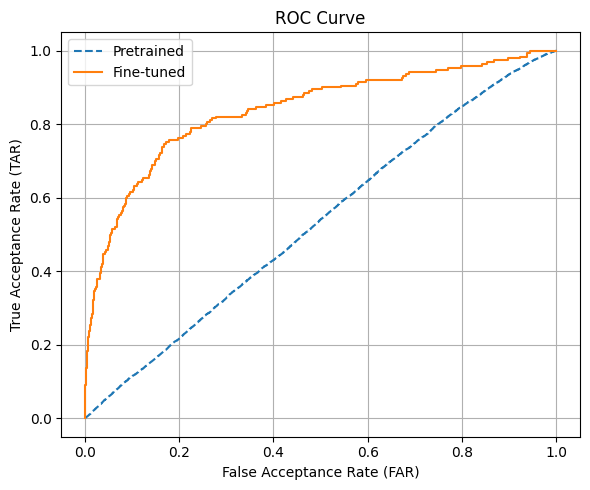

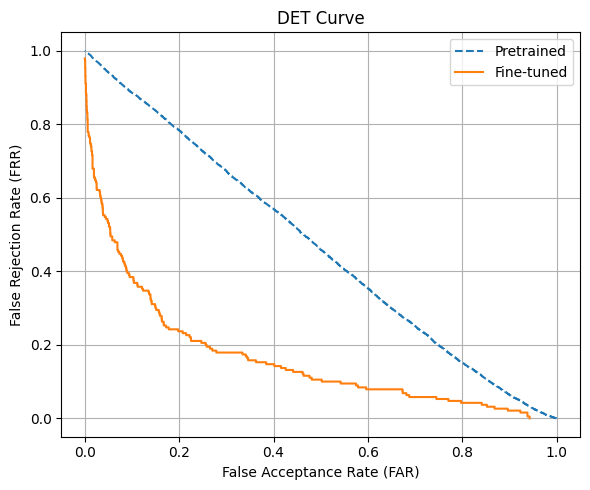

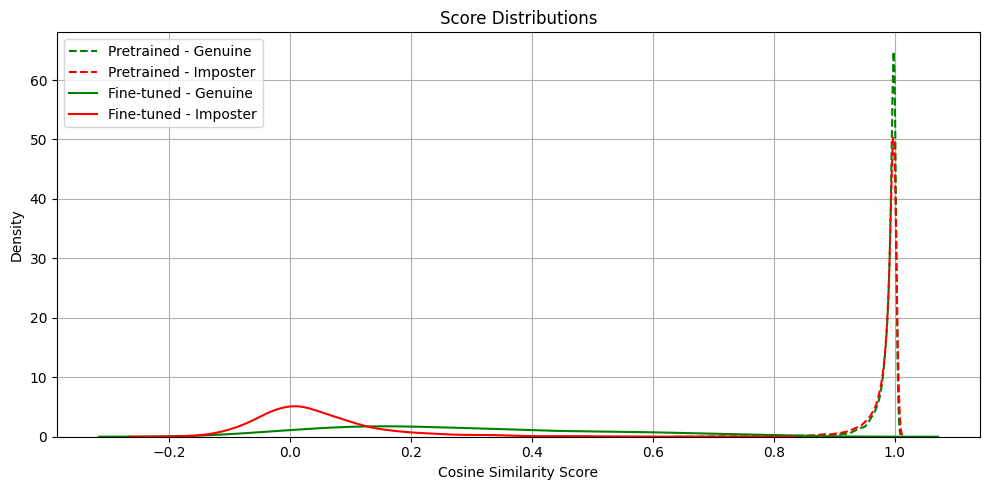

In [5]:
plot_roc_curve(pre_scores, pre_labels, fin_scores, fin_labels)
plot_det_curve(pre_scores, pre_labels, fin_scores, fin_labels)
plot_score_distribution(pre_scores, pre_labels, fin_scores, fin_labels)
